<a href="https://colab.research.google.com/github/Atk2045/data_bootcamp_final/blob/main/Model_2_EDA_and_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import libraries
!pip install fuzzywuzzy
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from fuzzywuzzy import fuzz, process
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
from google.colab import files
uploaded = files.upload()

Saving 2020-2021.csv to 2020-2021.csv
Saving 2021-2022.csv to 2021-2022.csv


In [5]:
relevant_columns = [
    'Div', 'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST',
    'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A',
    'Referee', 'HC', 'AC', 'HF', 'AF'
]

data_2020_2021 = pd.read_csv('2020-2021.csv', usecols=relevant_columns)
data_2021_2022 = pd.read_csv('2021-2022.csv', usecols=relevant_columns)

# Add season labels and combine
data_2020_2021['Season'] = '2020-2021'
data_2021_2022['Season'] = '2021-2022'
seasons_dataset = pd.concat([data_2020_2021, data_2021_2022], ignore_index=True)

# Show first few rows of combined data
seasons_dataset.head()


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,...,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
0,E0,12/09/2020,Fulham,Arsenal,0,3,A,C Kavanagh,5,13,...,2,3,2,2,0,0,6.00,4.33,1.53,2020-2021
1,E0,12/09/2020,Crystal Palace,Southampton,1,0,H,J Moss,5,9,...,7,3,2,1,0,0,3.10,3.25,2.37,2020-2021
2,E0,12/09/2020,Liverpool,Leeds,4,3,H,M Oliver,22,6,...,9,0,1,0,0,0,1.28,6.00,9.50,2020-2021
3,E0,12/09/2020,West Ham,Newcastle,0,2,A,S Attwell,15,15,...,8,7,2,2,0,0,2.15,3.40,3.40,2020-2021
4,E0,13/09/2020,West Brom,Leicester,0,3,A,A Taylor,7,13,...,2,5,1,1,0,0,3.80,3.60,1.95,2020-2021


In [6]:
# changes to the dataset for better readbility
seasons_dataset['Date'] = pd.to_datetime(seasons_dataset['Date'], format='%d/%m/%Y')
seasons_dataset['Goal Difference'] = seasons_dataset['FTHG'] - seasons_dataset['FTAG']
seasons_dataset['Total Shots'] = seasons_dataset['HS'] + seasons_dataset['AS']

In [7]:
# Copying the existing code for match data and aggregations
standings_data = seasons_dataset.copy()

# Match points calculated and win percentage obtained
standings_data['Home Points'] = standings_data['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
standings_data['Away Points'] = standings_data['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))
standings_data['Home Wins'] = standings_data['FTR'].apply(lambda x: 1 if x == 'H' else 0)
standings_data['Away Wins'] = standings_data['FTR'].apply(lambda x: 1 if x == 'A' else 0)
standings_data['Home Matches'] = 1
standings_data['Away Matches'] = 1
standings_data['Home Goals'] = standings_data['FTHG']
standings_data['Away Goals'] = standings_data['FTAG']

# Adding clean sheets calculations
standings_data['Home Clean Sheet'] = standings_data['FTAG'].apply(lambda x: 1 if x == 0 else 0)
standings_data['Away Clean Sheet'] = standings_data['FTHG'].apply(lambda x: 1 if x == 0 else 0)

# fixtures stats aggregated and table created
home_stats = standings_data.groupby('HomeTeam').agg({
    'Home Points': 'sum',
    'Home Wins': 'sum',
    'Home Matches': 'sum',
    'HY': 'sum',
    'HR': 'sum',
    'HS': 'sum',
    'HST': 'sum',
    'HF': 'sum',
    'HC': 'sum',
    'Home Goals': 'sum',
    'Home Clean Sheet': 'sum'  # Adding home clean sheets
}).rename(columns={
    'HY': 'Yellow Cards Home', 'HR': 'Red Cards Home', 'HS': 'Total Shots Home',
    'HST': 'Shots on Target Home', 'HF': 'Fouls Committed Home', 'HC': 'Corners Home'
})

away_stats = standings_data.groupby('AwayTeam').agg({
    'Away Points': 'sum',
    'Away Wins': 'sum',
    'Away Matches': 'sum',
    'AY': 'sum',
    'AR': 'sum',
    'AS': 'sum',
    'AST': 'sum',
    'AF': 'sum',
    'AC': 'sum',
    'Away Goals': 'sum',
    'Away Clean Sheet': 'sum'
}).rename(columns={
    'AY': 'Yellow Cards Away', 'AR': 'Red Cards Away', 'AS': 'Total Shots Away',
    'AST': 'Shots on Target Away', 'AF': 'Fouls Committed Away', 'AC': 'Corners Away'
})

standings = home_stats.merge(away_stats, left_index=True, right_index=True, how='outer', suffixes=('_Home', '_Away')).fillna(0)

# All the metrics in the table calculated from points to all the other stats
standings['Total Clean Sheets'] = standings['Home Clean Sheet'] + standings['Away Clean Sheet']
standings['Total Points'] = standings['Home Points'] + standings['Away Points']
standings['Total Wins'] = standings['Home Wins'] + standings['Away Wins']
standings['Total Matches'] = standings['Home Matches'] + standings['Away Matches']

standings['Win Percentage'] = (standings['Total Wins'] / standings['Total Matches'] * 100).round(2)
standings['Home Win Percentage'] = (standings['Home Wins'] / standings['Home Matches'] * 100).round(2)
standings['Away Win Percentage'] = (standings['Away Wins'] / standings['Away Matches'] * 100).round(2)

standings['Total Yellow Cards'] = standings['Yellow Cards Home'] + standings['Yellow Cards Away']
standings['Total Red Cards'] = standings['Red Cards Home'] + standings['Red Cards Away']

standings['Total Shots'] = standings['Total Shots Home'] + standings['Total Shots Away']
standings['Total Shots on Target'] = standings['Shots on Target Home'] + standings['Shots on Target Away']

standings['Total Fouls Committed'] = standings['Fouls Committed Home'] + standings['Fouls Committed Away']
standings['Total Corners'] = standings['Corners Home'] + standings['Corners Away']

standings['Total Goals'] = standings['Home Goals'] + standings['Away Goals']
standings['Home Goals Percentage'] = (standings['Home Goals'] / standings['Total Goals'] * 100).round(2)
standings['Away Goals Percentage'] = (standings['Away Goals'] / standings['Total Goals'] * 100).round(2)

# Table created and order made and sorted by points like the actual aggregated leaderboard and displayed with Team as index
standings_table = standings[['Total Points', 'Win Percentage', 'Home Win Percentage', 'Away Win Percentage',
                             'Total Wins', 'Total Goals', 'Home Goals Percentage', 'Away Goals Percentage',
                             'Total Yellow Cards', 'Total Red Cards', 'Yellow Cards Home', 'Yellow Cards Away',
                             'Red Cards Home', 'Red Cards Away', 'Total Shots', 'Total Shots Home', 'Total Shots Away',
                             'Total Shots on Target', 'Total Fouls Committed', 'Fouls Committed Home', 'Fouls Committed Away',
                             'Total Corners', 'Corners Home', 'Corners Away', 'Home Clean Sheet', 'Away Clean Sheet', 'Total Clean Sheets']]

standings_table = standings_table.sort_values(by='Total Points', ascending=False)
standings_table.reset_index(inplace=True)
standings_table = standings_table.rename(columns={'index': 'Team'})
standings_table.index += 1
standings_table.head(23)


,HomeTeam,Total Points,Win Percentage,Home Win Percentage,Away Win Percentage,Total Wins,Total Goals,Home Goals Percentage,Away Goals Percentage,Total Yellow Cards,...,Total Shots on Target,Total Fouls Committed,Fouls Committed Home,Fouls Committed Away,Total Corners,Corners Home,Corners Away,Home Clean Sheet,Away Clean Sheet,Total Clean Sheets
1,Man City,179,73.68,73.68,73.68,56,182,55.49,44.51,88,...,473,681,341,340,564,311,253,21,19,40
2,Liverpool,161,63.16,65.79,60.53,48,162,48.15,51.85,90,...,470,759,376,383,545,292,253,17,16,33
3,Chelsea,141,52.63,47.37,57.89,40,134,50.75,49.25,111,...,420,842,434,408,469,254,215,16,18,34
4,Tottenham,133,52.63,60.53,44.74,40,137,53.28,46.72,120,...,374,825,447,378,363,192,171,15,13,28
5,Man United,132,48.68,50.00,47.37,37,130,53.85,46.15,139,...,399,847,388,459,396,208,188,11,10,21
6,Arsenal,130,52.63,55.26,50.00,40,116,50.86,49.14,107,...,349,708,369,339,417,243,174,11,14,25
7,West Ham,121,46.05,50.00,42.11,35,122,53.28,46.72,95,...,323,698,359,339,359,193,166,10,9,19
8,Leicester,118,44.74,50.00,39.47,34,130,52.31,47.69,114,...,354,772,388,384,399,205,194,12,6,18
9,Aston Villa,100,38.16,34.21,42.11,29,107,54.21,45.79,140,...,349,840,422,418,411,210,201,12,14,26
10,Everton,98,36.84,39.47,34.21,28,90,56.67,43.33,134,...,286,754,361,393,328,191,137,9,11,20


In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_error_handle(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.google.com/'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

def team_expenditures(url):
    soup = scrape_error_handle(url)
    if not soup:
        print("Failed to fetch data from Transfermarkt.")
        return pd.DataFrame()

    rows = soup.find_all('tr')
    scraped_team_dict = {}

    for row in rows:
        # Check for the presence of the required elements in the row to avoid index errors
        team_column = row.find('td', class_='hauptlink no-border-links')
        expenditure_column = row.find('td', class_='rechts hauptlink redtext')
        income_column = row.find('td', class_='rechts hauptlink greentext')

        balance_columns = row.find_all('td', class_='rechts')
        zentriert_columns = row.find_all('td', class_='zentriert')

        if team_column and expenditure_column and income_column and len(balance_columns) > 0 and len(zentriert_columns) > 3:
            team_name = team_column.find('a').text.strip()
            expenditure_text = expenditure_column.text.strip()
            income_text = income_column.text.strip()
            balance_text = balance_columns[-1].text.strip()  # Assumes balance is the last `rechts` column
            arrivals = zentriert_columns[2].text.strip()  # Arrivals are at index 2
            departures = zentriert_columns[3].text.strip()  # Departures are at index 3

            # Add all columns to the dictionary
            scraped_team_dict[team_name] = {
                'Expenditure': expenditure_text,
                'Income': income_text,
                'Balance': balance_text,
                'Arrivals': arrivals,
                'Departures': departures
            }

    # Create DataFrame from the dictionary
    df_league_teams = pd.DataFrame.from_dict(scraped_team_dict, orient='index').reset_index()
    df_league_teams.columns = ['Hometeam', 'Expenditure', 'Income', 'Balance', 'Arrivals', 'Departures']

    # Convert monetary values to millions for consistency
    def unit_convertor(value):
        value = value.replace('€', '').strip()
        if value.endswith('bn'):
            return float(value.replace('bn', '').replace(',', '.')) * 1000  # Convert billion to million
        elif value.endswith('m'):
            return float(value.replace('m', '').replace(',', '.'))
        elif value.endswith('k'):
            return float(value.replace('k', '').replace(',', '.')) / 1000  # Convert thousand to million
        return 0

    # Apply the conversion to financial columns
    for column in ['Expenditure', 'Income', 'Balance']:
        df_league_teams[column] = df_league_teams[column].apply(unit_convertor)

    # Sort and get the top 23 teams by expenditure
    df_top_10 = df_league_teams.sort_values(by='Expenditure', ascending=False).head(23)
    return df_top_10

# Test the function with the Transfermarkt URL
url_transfermarkt = "https://www.transfermarkt.us/premier-league/einnahmenausgaben/wettbewerb/GB1/plus/0?ids=a&sa=&saison_id=2020&saison_id_bis=2021&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0"
expenditure_df = team_expenditures(url_transfermarkt)
print(expenditure_df)


                   Hometeam  Expenditure  Income  Balance Arrivals Departures
0                Chelsea FC       365.20  211.84  -153.37       52         49
1           Manchester City       312.30  157.80  -154.50       49         51
2                Arsenal FC       253.40   50.55  -202.85       29         36
3               Aston Villa       231.15  129.77  -101.38       34         33
4         Manchester United       225.95   50.60  -175.35       33         31
5         Tottenham Hotspur       206.40   47.92  -158.48       29         30
6              Leeds United       187.10    0.00  -187.10       29         31
7              Liverpool FC       176.80   48.85  -127.95       31         25
8          Newcastle United       169.25    0.78  -168.47       22         25
9           West Ham United       129.20   49.65   -79.56       26         25
10           Leicester City       127.00   57.77   -69.23       31         29
11  Wolverhampton Wanderers       125.19  111.00   -14.19       

In [9]:
# Renaming for standardization
expenditure_df = expenditure_df.rename(columns={'Hometeam': 'Team'})
standings_table['Team'] = standings_table['HomeTeam'].str.strip().str.lower()
expenditure_df['Team'] = expenditure_df['Team'].str.strip().str.lower()

# Mapping needed to change the team names since they were not the same
team_name_mapping = {'chelsea': 'chelsea fc',
    'man city': 'manchester city',
    'arsenal': 'arsenal fc',
    'aston villa': 'aston villa',
    'man united': 'manchester united',
    'tottenham': 'tottenham hotspur',
    'leeds': 'leeds united',
    'liverpool': 'liverpool fc',
    'newcastle': 'newcastle united',
    'west ham': 'west ham united',
    'leicester': 'leicester city',
    'wolves': 'wolverhampton wanderers',
    'brighton': 'brighton & hove albion',
    'everton': 'everton fc',
    'crystal palace': 'crystal palace',
    'southampton': 'southampton fc',
    'norwich': 'norwich city',
    'sheffield': 'sheffield united',
    'fulham': 'fulham fc',
    'west brom': 'west bromwich albion',
    'burnley': 'burnley fc',
    'brentford': 'brentford fc',
    'watford': 'watford fc'
}

standings_table['Team'] = standings_table['Team'].replace(team_name_mapping)
expenditures_with_performance = expenditure_df.merge(standings_table, on='Team', how='left')

# Sort by 'Total Points' in descending order
expenditures_with_performance = expenditures_with_performance.sort_values(by='Total Points', ascending=False)
expenditures_with_performance.reset_index(drop=True, inplace=True)
expenditures_with_performance.index += 1
expenditures_with_performance.head(23)


,Team,Expenditure,Income,Balance,Arrivals,Departures,HomeTeam,Total Points,Win Percentage,Home Win Percentage,...,Total Shots on Target,Total Fouls Committed,Fouls Committed Home,Fouls Committed Away,Total Corners,Corners Home,Corners Away,Home Clean Sheet,Away Clean Sheet,Total Clean Sheets
1,manchester city,312.30,157.80,-154.50,49,51,Man City,179,73.68,73.68,...,473,681,341,340,564,311,253,21,19,40
2,liverpool fc,176.80,48.85,-127.95,31,25,Liverpool,161,63.16,65.79,...,470,759,376,383,545,292,253,17,16,33
3,chelsea fc,365.20,211.84,-153.37,52,49,Chelsea,141,52.63,47.37,...,420,842,434,408,469,254,215,16,18,34
4,tottenham hotspur,206.40,47.92,-158.48,29,30,Tottenham,133,52.63,60.53,...,374,825,447,378,363,192,171,15,13,28
5,manchester united,225.95,50.60,-175.35,33,31,Man United,132,48.68,50.00,...,399,847,388,459,396,208,188,11,10,21
6,arsenal fc,253.40,50.55,-202.85,29,36,Arsenal,130,52.63,55.26,...,349,708,369,339,417,243,174,11,14,25
7,west ham united,129.20,49.65,-79.56,26,25,West Ham,121,46.05,50.00,...,323,698,359,339,359,193,166,10,9,19
8,leicester city,127.00,57.77,-69.23,31,29,Leicester,118,44.74,50.00,...,354,772,388,384,399,205,194,12,6,18
9,aston villa,231.15,129.77,-101.38,34,33,Aston Villa,100,38.16,34.21,...,349,840,422,418,411,210,201,12,14,26
10,everton fc,113.87,50.43,-63.45,33,35,Everton,98,36.84,39.47,...,286,754,361,393,328,191,137,9,11,20


In [10]:
expenditures_with_performance.describe()

,Expenditure,Income,Balance,Total Points,Win Percentage,Home Win Percentage,Away Win Percentage,Total Wins,Total Goals,Home Goals Percentage,...,Total Shots on Target,Total Fouls Committed,Fouls Committed Home,Fouls Committed Away,Total Corners,Corners Home,Corners Away,Home Clean Sheet,Away Clean Sheet,Total Clean Sheets
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,145.477826,65.562609,-79.916087,91.695652,36.040870,37.642609,34.440000,25.608696,91.086957,51.195652,...,288.304348,693.695652,351.565217,342.130435,340.565217,184.391304,156.173913,10.086957,8.869565,18.956522
std,88.352368,50.998536,73.235558,45.979674,16.494183,17.172281,16.847804,14.528152,45.369105,5.728718,...,115.011634,175.761314,91.862954,86.096829,123.919265,65.941254,59.582374,4.860911,5.353880,9.627037
min,43.500000,0.000000,-202.850000,22.000000,13.160000,10.530000,10.530000,5.000000,20.000000,33.330000,...,99.000000,356.000000,185.000000,171.000000,145.000000,84.000000,45.000000,1.000000,1.000000,4.000000
25%,69.920000,35.990000,-153.935000,60.000000,25.000000,25.000000,21.050000,15.000000,57.500000,49.075000,...,204.500000,582.500000,289.000000,293.000000,246.000000,129.000000,108.500000,7.000000,4.500000,12.000000
50%,125.190000,50.550000,-69.230000,96.000000,35.530000,36.840000,34.210000,27.000000,90.000000,52.170000,...,295.000000,772.000000,387.000000,381.000000,363.000000,194.000000,169.000000,10.000000,9.000000,20.000000
75%,196.750000,85.000000,-17.890000,125.500000,47.365000,50.000000,43.425000,36.000000,126.000000,54.810000,...,353.500000,824.500000,419.000000,397.000000,411.500000,212.000000,191.000000,12.500000,12.500000,24.000000
max,365.200000,211.840000,39.850000,179.000000,73.680000,73.680000,73.680000,56.000000,182.000000,60.000000,...,473.000000,896.000000,463.000000,459.000000,564.000000,311.000000,253.000000,21.000000,19.000000,40.000000


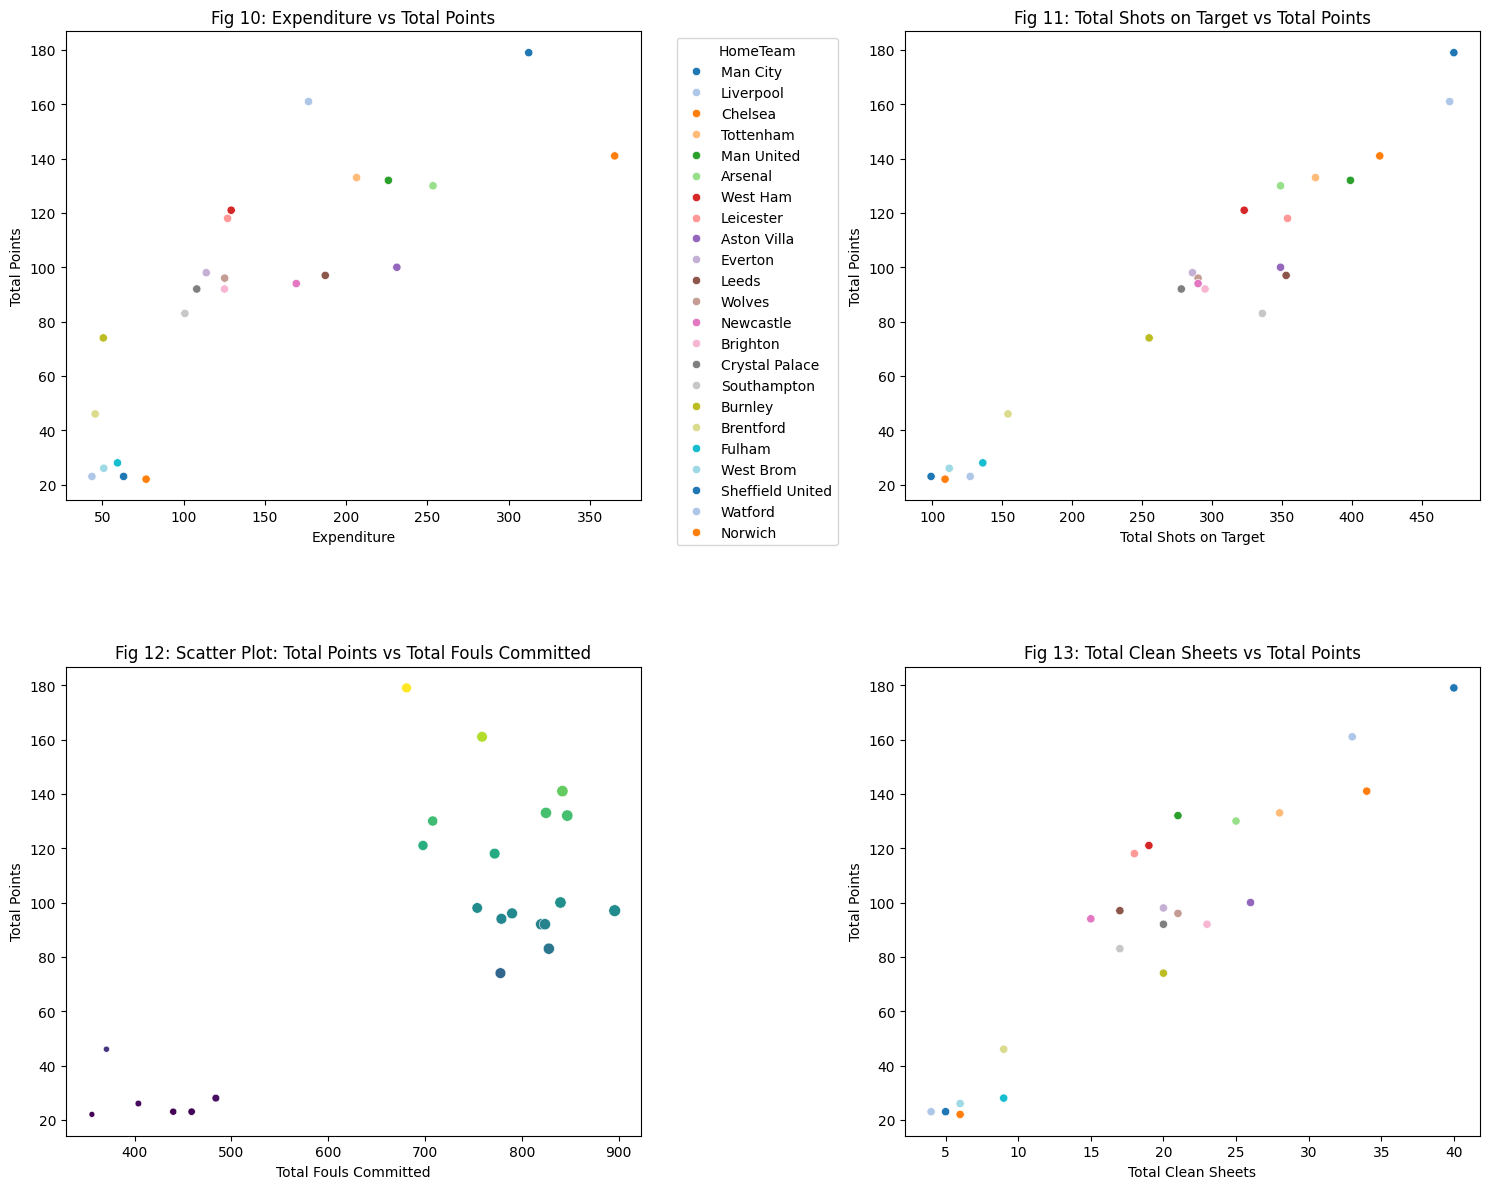

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Expenditure vs Total Points
sns.scatterplot(data=expenditures_with_performance, x='Expenditure', y='Total Points', hue='HomeTeam', ax=axes[0, 0], palette='tab20')
axes[0, 0].set_title('Fig 10: Expenditure vs Total Points')
axes[0, 0].set_xlabel('Expenditure')
axes[0, 0].set_ylabel('Total Points')
axes[0, 0].legend(title='HomeTeam', bbox_to_anchor=(1.05, 1), loc='upper left')

# Total Shots on Target vs Total Points
sns.scatterplot(data=expenditures_with_performance, x='Total Shots on Target', y='Total Points', hue='HomeTeam', ax=axes[0, 1], palette='tab20')
axes[0, 1].set_title('Fig 11: Total Shots on Target vs Total Points')
axes[0, 1].set_xlabel('Total Shots on Target')
axes[0, 1].set_ylabel('Total Points')
axes[0, 1].legend_.remove()

# Scatter Plot: Total Points vs Total Fouls Committed
sns.scatterplot(data=expenditures_with_performance, x='Total Fouls Committed', y='Total Points', hue='Total Points', size='Total Fouls Committed', palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('Fig 12: Scatter Plot: Total Points vs Total Fouls Committed')
axes[1, 0].set_xlabel('Total Fouls Committed')
axes[1, 0].set_ylabel('Total Points')
axes[1, 0].legend_.remove()  #


# Total Clean Sheets vs Total Points
sns.scatterplot(data=expenditures_with_performance, x='Total Clean Sheets', y='Total Points', hue='HomeTeam', ax=axes[1, 1], palette='tab20')
axes[1, 1].set_title('Fig 13: Total Clean Sheets vs Total Points')
axes[1, 1].set_xlabel('Total Clean Sheets')
axes[1, 1].set_ylabel('Total Points')
axes[1, 1].legend_.remove()

# Show the plots
plt.tight_layout()
plt.show()


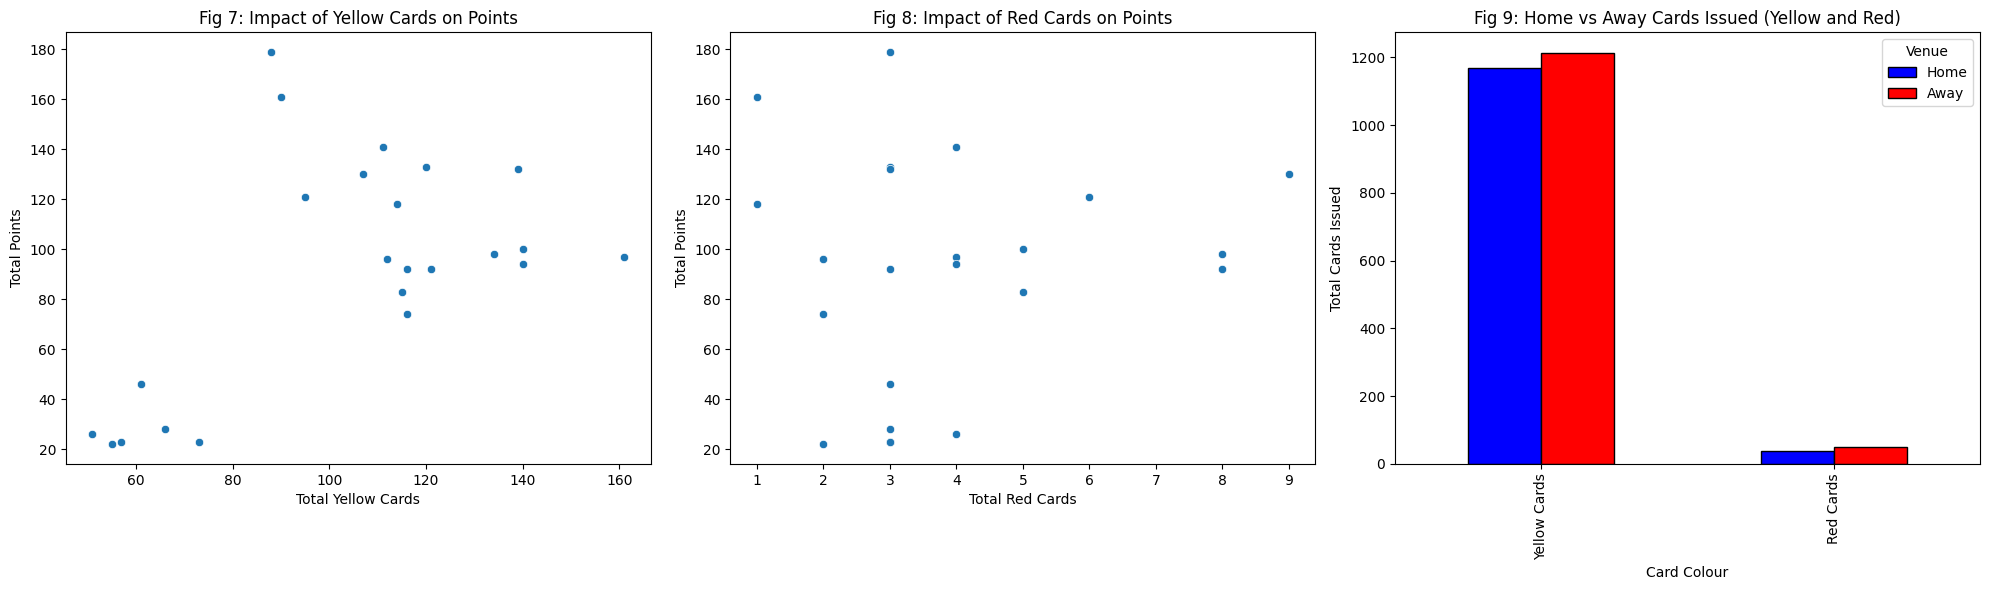

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Yellow Cards vs. Total Points in a scatter plot
sns.scatterplot(x='Total Yellow Cards', y='Total Points', data=standings_table, ax=axes[0])
axes[0].set_title('Fig 7: Impact of Yellow Cards on Points')
axes[0].set_xlabel('Total Yellow Cards')
axes[0].set_ylabel('Total Points')

# Red Cards vs. Total Points in a scatter plot
sns.scatterplot(x='Total Red Cards', y='Total Points', data=standings_table, ax=axes[1])
axes[1].set_title('Fig 8: Impact of Red Cards on Points')
axes[1].set_xlabel('Total Red Cards')
axes[1].set_ylabel('Total Points')

# Home vs Away Cards Issued in a double bar chart with yellow and red cards
home_away_cards = standings_table[['Yellow Cards Home', 'Yellow Cards Away', 'Red Cards Home', 'Red Cards Away']].sum()
card_data = pd.DataFrame({
    'Home': [home_away_cards['Yellow Cards Home'], home_away_cards['Red Cards Home']],
    'Away': [home_away_cards['Yellow Cards Away'], home_away_cards['Red Cards Away']]
}, index=['Yellow Cards', 'Red Cards'])

card_data.plot(kind='bar', color=['blue', 'red'], edgecolor='black', ax=axes[2])
axes[2].set_title('Fig 9: Home vs Away Cards Issued (Yellow and Red)')
axes[2].set_xlabel('Card Colour')
axes[2].set_ylabel('Total Cards Issued')
axes[2].legend(title='Venue')

plt.tight_layout()
plt.show()


In [84]:
# Select relevant columns for correlation
relevant_metrics = expenditures_with_performance[['Expenditure', 'Income', 'Balance', 'Total Shots on Target',
            'Total Fouls Committed', 'Home Clean Sheet', 'Away Clean Sheet', 'Total Corners', 'Total Points']]

corr_matrix = relevant_metrics.corr().round(2)
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    showscale=True

)
fig.update_layout(
    width=1000,
    height=800,
    title="Fig 10: Correlation Matrix of Financial and Performance Metrics",
    title_x=0.5,
    title_y=0.05
)

fig.show()

In [19]:
df = expenditures_with_performance
# Baseline Model: Mean Prediction
y = df['Total Points']  # Target variable
baseline_preds = np.ones(len(y)) * y.mean()
baseline_mse = mean_squared_error(y, baseline_preds)
print(f"Baseline MSE: {baseline_mse:.2f}")
print(f"Baseline RMSE: {np.sqrt(baseline_mse):.2f}")




Baseline MSE: 2022.21
Baseline RMSE: 44.97


In [39]:
features = ['Expenditure', 'Income', 'Balance', 'Total Shots on Target',
            'Total Fouls Committed', 'Home Clean Sheet', 'Away Clean Sheet', 'Total Corners']
target = 'Total Points'

X = df[features]
y = df[target]

# Train-test split and pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), features)
])


In [82]:
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
linear_pipeline.fit(X_train, y_train)

# Model Evaluation
y_test_preds = linear_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_preds)
print(f"Linear Regression Test MSE: {test_mse:.2f}")
print(f"Linear Regression Test RMSE: {np.sqrt(test_mse):.2f}")

# Feature Importance
r = permutation_importance(linear_pipeline, X_test, y_test, n_repeats=10)
importance_df = pd.DataFrame({'Feature': features, 'Importance': r['importances_mean']})
print("Feature Importance (Linear Regression):")
print(importance_df.sort_values(by='Importance', ascending=False))
display(importance_df)



Linear Regression Test MSE: 127.76
Linear Regression Test RMSE: 11.30
Feature Importance (Linear Regression):
                 Feature    Importance
0            Expenditure  3.366898e+06
2                Balance  1.344167e+06
1                 Income  5.539690e+05
3  Total Shots on Target  1.620320e+00
5       Home Clean Sheet  6.489139e-02
4  Total Fouls Committed  4.501275e-02
6       Away Clean Sheet  2.382413e-02
7          Total Corners  2.016469e-03


,Feature,Importance
0,Expenditure,3.366898e+06
1,Income,5.539690e+05
2,Balance,1.344167e+06
3,Total Shots on Target,1.620320e+00
4,Total Fouls Committed,4.501275e-02
5,Home Clean Sheet,6.489139e-02
6,Away Clean Sheet,2.382413e-02
7,Total Corners,2.016469e-03


Random Forest Best Parameters: {'model__max_depth': 5, 'model__n_estimators': 200}
Feature Importance (Random Forest):
                 Feature  Importance
3  Total Shots on Target    0.238803
4  Total Fouls Committed    0.150158
7          Total Corners    0.148338
6       Away Clean Sheet    0.143905
0            Expenditure    0.141753
5       Home Clean Sheet    0.140823
2                Balance    0.022651
1                 Income    0.013569


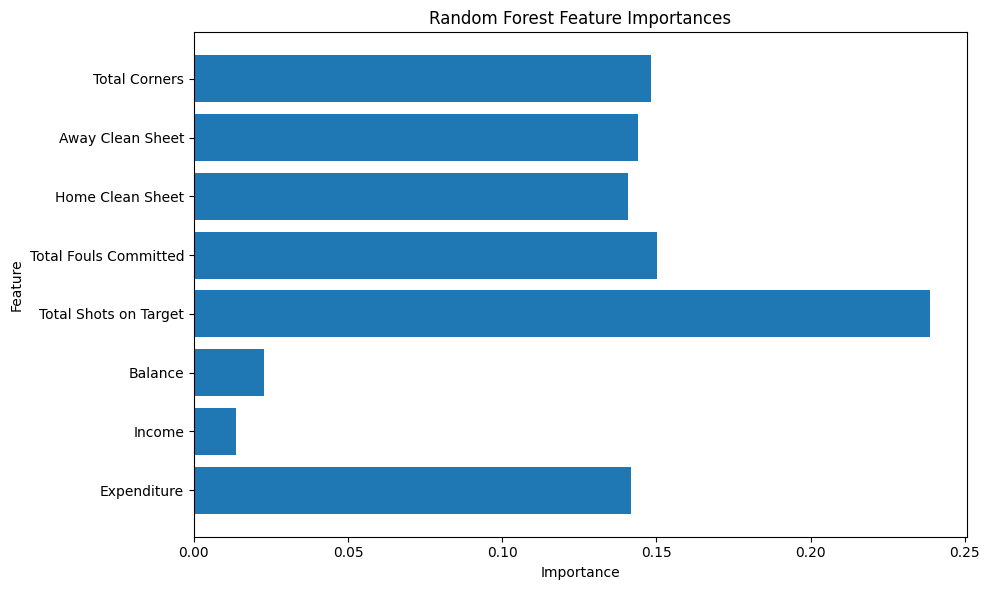

MSE: 365.40
RMSE: 19.12


In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=20))
])

param_grid = {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 5, 10]}

# Grid Search
rf_grid = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

print(f"Random Forest Best Parameters: {rf_grid.best_params_}")

# Feature Importance
rf_best_model = rf_grid.best_estimator_
importances = rf_best_model.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print("Feature Importance (Random Forest):")
print(importance_df.sort_values(by='Importance', ascending=False))

# Predictions on test set
y_pred = rf_best_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")



Gradient Boosting Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50}


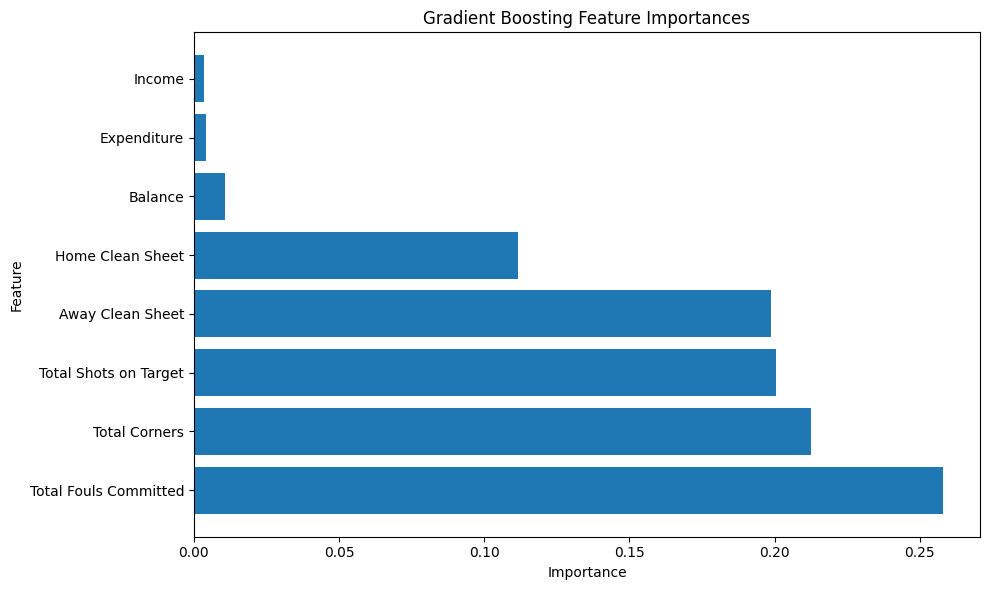

MSE: 621.54
RMSE: 24.93


In [80]:
from sklearn.ensemble import GradientBoostingRegressor
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=20))
])

param_grid = {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}
gb_grid = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
print(f"Gradient Boosting Best Parameters: {gb_grid.best_params_}")

y_pred_gb = gb_best_model.predict(X_test)

# Feature Importance and sorted descending
gb_best_model = gb_grid.best_estimator_
importances = gb_best_model.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Gradient Boosting Feature Importances')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
print(f"MSE: {mse:.2f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"RMSE: {rmse:.2f}")

In [79]:
from sklearn.metrics import r2_score
results = {}
for name, model in models.items():
    y_test_preds = model.predict(X_test)
    r2 = r2_score(y_test, y_test_preds)
    mse = mean_squared_error(y_test, y_test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_preds)
    results[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Create a pandas DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.to_csv('model_evaluation_results.csv')

styled_df = results_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
]).format("{:.2f}")  # Format to 2 decimal places without trailing zeros


# Display the styled DataFrame
display(styled_df)


,MSE,RMSE,MAE,R2
Linear Regression,127.76,11.30,8.20,0.93
Random Forest,365.40,19.12,15.65,0.81
Gradient Boosting,621.54,24.93,22.77,0.67
